#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

In [2]:
YEAR = 2015

# OCR with Adobe Acrobat and extraction with fitz

In [3]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

### Extract text

In [4]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_{}.pdf".format(YEAR))
print('Number of pages:', len(doc))

Number of pages: 838


In [5]:
def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    text_by_row = []
    temp = []
    init_y = text[0][1] #y0
    i = 0
    while i < len(text):
        if (text[i][1] < init_y + threshold) and (text[i][1] > init_y - threshold):
            temp.append(text[i][4])
        else:
            text_by_row.append(temp)
            temp = [text[i][4]]
            init_y = int(text[i][1])
        i += 1
    text_by_row.append(temp)
    return text_by_row

- Extract keys

In [6]:
#keys for treatment
abbr_keys = {}
pagen = 5
words = doc[pagen - 1].getText("words")
words = [word for word in words if (word[1] > 60 and word[1] < 700)]
words_left = text_to_rows([word for word in words if (word[0] < 300)], 5)
words_right = text_to_rows([word for word in words if (word[0] > 300)], 5)

In [7]:
for line in words_left:
    if line[0].isupper():
        abbr_keys[line[0]] = ' '.join(line[1:])

In [8]:
#keys with two lines
abbr_keys['ODT'] = "Outpatient Day Treatment or Partial Hospitalization" 
abbr_keys['OMB'] = "Outpatient Methadone/Buprenorphine or Vivitrol®"
abbr_keys['SI'] = "State Financed Health Insurance Plan Other Than Medicaid"

In [9]:
for line in words_right:
    if re.match(r'(?:[A-Z]+)$', line[0]):
        abbr_keys[line[0]] = ' '.join(line[1:])

In [10]:
#keys with two lines
abbr_keys['PA'] = "Payment Assistance (Check with facility for details)" 
abbr_keys['SS'] = "Sliding Fee Scale (Fee is based on income and other factors)"
abbr_keys['CJ'] = "Clients Referred from the Court/Judicial System"
abbr_keys['CO'] = "Persons with Co-occurring Mental and Substance Use Disorders"
abbr_keys['DV'] = "Persons who have Experienced Intimate Partner Violence, Domestic Violence"
abbr_keys['GL'] = "Lesbian, Gay, Bisexual, or Transgender (LGBT) Clients"
abbr_keys['BMO'] = "Methadone and Buprenorphine Clients Only"

In [11]:
len(abbr_keys)

69

In [12]:
#keys for language
pagen = 6
words = doc[pagen - 1].getText("words")
page6 = text_to_rows(words, 5)

In [13]:
key = ''
for line in page6[7:14]:
    for word in line:
        if word[-1].isnumeric():
            key = word
        else:
            abbr_keys[key] = word

In [14]:
key = ''
for line in page6[16:]:
    for word in line:
        if word[-1].isnumeric():
            key = word
        else:
            abbr_keys[key] = word

In [15]:
abbr_keys['N73'] = 'Anishinaabemowin'

In [16]:
abbr_keys['N35'] = 'Tohono O’odham'

In [17]:
abbr_keys['N13N18'] = None

In [18]:
abbr_keys

{'GHF': 'General Health Services',
 'MHF': 'Mental Health Treatment Services',
 'MHSAF': 'Mix of Mental Health and Substance Abuse',
 'SAF': 'Substance Abuse Treatment Services',
 'BU': 'Buprenorphine Used in Treatment',
 'DM': 'Methadone Detoxification',
 'DT': 'Detoxification',
 'HH': 'Transitional Housing or Halfway House',
 'MM': 'Methadone Maintenance',
 'NXN': 'Naltrexone (oral)',
 'OTPA': 'All Clients in Opioid Treatment Program',
 'SA': 'Substance Abuse Treatment Services',
 'VTRL': 'Vivitrol® (Injectable Naltrexone)',
 'CT': 'Computerized Treatment',
 'HI': 'Hospital Inpatient',
 'HID': 'Hospital Inpatient Detoxification',
 'HIT': 'Hospital Inpatient Treatment',
 'OD': 'Outpatient Detoxification',
 'ODT': 'Outpatient Day Treatment or Partial Hospitalization',
 'OIT': 'Intensive Outpatient Treatment',
 'OMB': 'Outpatient Methadone/Buprenorphine or Vivitrol®',
 'OP': 'Outpatient',
 'ORT': 'Regular Outpatient Treatment',
 'PH': 'Partial Hospitalization/Day Treatment',
 'RD': 'Res

In [19]:
import numpy as np
np.save('keys.npy'.format(YEAR), abbr_keys) 

- Explore text

In [83]:
# - explore the page set up - 
# select a page
pagen = 13
words = doc[pagen - 1].getText("words")

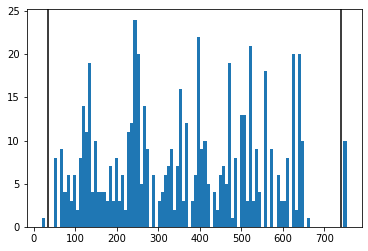

In [86]:
# check the y distribution to remove top and bottom crap...
y0s = [word[1] for word in words]
a = plt.hist(y0s, bins = 100)
plt.axvline(35, color='black')
plt.axvline(740, color='black')

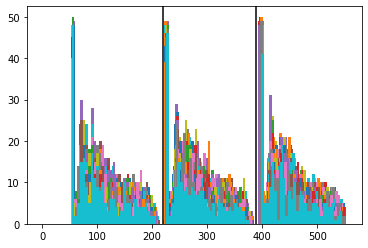

In [91]:
#to find column seperation
for pagen in range(100, 500):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if word[1] > 35]
    words = [word for word in words if word[1] < 740]
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 100)
    
plt.axvline(219, color='black')
plt.axvline(388, color='black')

- Read text from PDF

In [92]:
def get_words_in_box(page, ulim, blim, col1lim, col2lim):
    '''
    Extract words from each column of the PDF.
    '''
    page_txt = []
    words = page.getText("words") 
    #cut off top and bottom
    words = [word for word in words if word[1] > ulim]
    words = [word for word in words if word[1] < blim]
    #get three columns
    page_txt.append(text_to_rows([word for word in words if word[0] < col1lim], 5))
    page_txt.append(text_to_rows([word for word in words if ((word[0] > col1lim) and (word[0] < col2lim))], 5))
    page_txt.append(text_to_rows([word for word in words if word[0] > col2lim], 5))
    return page_txt

In [98]:
#testing
#get_words_in_box(doc[12], 35, 740, 219, 388)
#blanck page
#get_words_in_box(doc[27], 35, 740, 219, 388)

In [99]:
#run
data = []
for pagen in range(13, 839):
    data.append(get_words_in_box(doc[pagen-1], 35, 740, 219, 388))

# Write data into csv

- Checking + cleaning each part of data

In [127]:
#['F81', 'F92', 'N23', 'N24', 'N40', 'N13N18']
def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    '''
    if '\uf073' in line:
        return True
    if not any(x not in abbr_keys for x in line):
        return True
    if line[0] in abbr_keys:
        if len(line) > 2 and line[1] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
        if len(line) > 3 and line[2] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
    return False

def clean_keys(line):
    if 'N13N18' in line:
        line.remove('N13N18')
        line += ['N13', 'N18']
    return '/'.join([key for key in line if key != '\uf073']) + '/'

In [109]:
#['Nogales,', 'AZ', '85621']
#['Chesapeake', 'Beach,', 'MD', '20732']
def is_citystatezip(line):
    if line[-1].isnumeric() and len(line[-1]) == 5 and line[-2].isupper() and len(line[-2]) == 2 and line[-3][-1] == ',':
        return True
    return False

def clean_citystatezip(line):
    return [' '.join(line[:-2])[:-1], line[-2], line[-1]]

In [110]:
#['(205)', '216-0200'],
#['Intake:', '(205)', '216-0202'],
#['Hotlines:', '(888)', '950-4325', '(888)', '950HEAL']
#['6552x']
def is_contact(line):
    if line[0] == 'Intake:' or line[0] == 'Intakes:' or line[0] == 'Hotline:'or line[0] == 'Hotlines:':
        return True
    if len(line[0]) < 5:
        return False
    if line[0][0] == '(' and line[0][4] == ')' and line[0][1:4].isnumeric():
        return True
    if line[0][:4].isnumeric() and line[0][4] == 'x':
        return True
    return False

def clean_contact(line):
    l = ''
    for word in line:
        if len(word) == 5 and word[0] == '(':
            l += word
        else:
            l += word + ' '
    return l.strip()

In [111]:
address_indicators = ['P.0.', 'P.O', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'Suite', 'Suites', 'Drive', 'Boulevard', \
                      'Annex', 'Streets','Floor', 'Fl', 'Bldg', 'Rear', 'Room', 'Basement'] ##
name_indicators = ['Clinic', 'Medical', 'Inc', 'Health', 'Services', 'Treatment']

def is_address(line):
    if (not line[0].replace('-', '').isnumeric()) and any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

In [112]:
# #for testing
# for page_data in data:
#     for col in page_data:
#         for line in col:
#             for word in line:
#                 if word[0] == 'F' and word[-1].isnumeric() and word not in abbr_keys:
#                     print(line)

- Split data into MOUDs

In [113]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    while i < len(col_text) - 1:
        if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
            temp.append(col_text[i])
            col_text_splitted.append(temp)
            temp = []
        elif is_keys(col_text[i]) and (is_keys(col_text[i+1])):
            temp.append(col_text[i])
        else:
            if (not re.match(r'(?:[A-Z]+)$', ''.join(col_text[i]))):
                #if not keys and only upper characters, then ignore as name of city.
                temp.append(col_text[i])
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

- Write data

In [114]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('') 
            #name3
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not is_keys(facil[i]):##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
                while i < len(facil):
                    if is_contact(facil[i]):
                        data_holder[-1] += ' ' + clean_contact(facil[i])
                        i += 1
                    else:
                        break
            else:
                data_holder.append('')
            #note
            if not is_keys(facil[i]):
                data_holder.append(' '.join(facil[i]))
                i += 1
            else:
                data_holder.append('')
            #keys
            data_holder.append('')
            for keys in facil[i:]:
                data_holder[-1] += clean_keys(keys)
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [115]:
#clean_col_data(splitted_data[0][0])

In [129]:
filename = "{}.csv".format(YEAR)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", 'Name3', "Address1", "Address2", "Address3", "City", "State", "ZIP_Code", "Contact", "Note", "Keys"])

In [130]:
pagen = 13

for page in data:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        if col != []:
            page_data_holders += clean_col_data(split_col_data(col))
            print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 13..... Finished Col ...... Finished Col ..... Finished Col 
Page: 14..... Finished Col ...... Finished Col ..... Finished Col 
Page: 15..... Finished Col ..... Finished Col ..... Finished Col 
Page: 16..... Finished Col ...... Finished Col ..... Finished Col 
Page: 17..... Finished Col ...... Finished Col ..... Finished Col 
Page: 18..... Finished Col ..... Finished Col ..... Finished Col 
Page: 19..... Finished Col ..... Finished Col ..... Finished Col 
Page: 20..... Finished Col ..... Finished Col ..... Finished Col 
Page: 21.... Finished Col 
Page: 22
Page: 23..... Finished Col ..... Finished Col ..... Finished Col 
Page: 24..... Finished Col ..... Finished Col .... Finished Col 
Page: 25..... Finished Col ..... Finished Col ..... Finished Col 
Page: 26..... Finished Col ..... Finished Col ..... Finished Col 
Page: 27..... Finished Col ..... Finished Col .... Finished Col 
Page: 28
Page: 29..... Finished Col ..... Finished Col ..... Finished Col 
Page: 30..... Finished Col ..

In [131]:
#check error data
# no errors??

- Rewrite data in problem pages

In [133]:
# ^^

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [134]:
import pandas as pd

In [135]:
df = pd.read_csv("{}.csv".format(YEAR))
df

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Note,Keys
0,SpectraCare,Henry County/IOP,NaN,219 Dothan Road,NaN,NaN,Abbeville,AL,36310,(334)673-2143,NaN,MHF/SA/OP/ORT/SF/MD/SI/PI/MI/SS/PA/AH/YAD/ADLT...
1,Shelby County Treatment Center,NaN,NaN,750 Highway 31 South,NaN,NaN,Alabaster,AL,35007,(205)216-0200,NaN,SAF/SA/MM/BU/NXN/VTRL/OP/OMB/OIT/ORT/CT/SF/MD/...
2,Lighthouse of Tallapoosa County Inc,Substance Abuse Rehab Program/Resid,NaN,36 Franklin Street,NaN,NaN,Alexander City,AL,35010,(256)234-4894,NaN,SAF/SA/HH/RES/RL/SF/MD/AH/MN/YAD/ADLT/MALE/
3,South Central Alabama CMHC,Covington Cnty Adult SA OP,NaN,205 Academy Drive,NaN,NaN,Andalusia,AL,36420,(334)428-5050 Intake: (334)428-5040,NaN,SAF/SA/OP/ORT/SF/MD/MC/PI/MI/SS/AH/YAD/ADLT/FE...
4,South Central Alabama CMHC,First Step,NaN,205 Academy Drive,NaN,NaN,Andalusia,AL,36420,(334)428-5002 Intake: (334)428-5050,NaN,SAF/SA/RES/RS/SF/MD/MC/PI/MI/SS/AH/YAD/ADLT/MALE/
...,...,...,...,...,...,...,...,...,...,...,...,...
11923,Northern Wyoming Mental Health Center,NaN,NaN,420 1/2 Main Street,NaN,NaN,Sundance,WY,82729,(307)283-3636,NaN,MHSAF/SA/NXN/VTRL/OP/OIT/ORT/CT/SF/MD/MC/PI/MI...
11924,Hot Springs County Csl Servs Inc,NaN,NaN,121 South 4th Street,NaN,NaN,Thermopolis,WY,82443,(307)864-3138 Intake: (307)864-2247,NaN,MHSAF/SA/OP/OIT/ORT/CT/SF/MD/SI/PI/MI/SS/PA/DU...
11925,Peak Wellness Center,Goshen County Clinic,NaN,501 Albany Avenue,NaN,NaN,Torrington,WY,82240,(307)532-4091,NaN,SA/NXN/OP/OIT/ORT/CT/SF/MD/MC/PI/MI/SS/PA/AH/S...
11926,Peak Wellness Center,Substance Abuse Services,NaN,1954 West Mariposa Parkway,NaN,NaN,Wheatland,WY,82201,(307)322-3190,NaN,MHSAF/SA/DT/NXN/VTRL/OP/OD/OIT/ORT/CT/SF/MD/MC...


In [136]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[7])!=2:
        print(row)

In [137]:
#check if all zip codes are correct
df.dtypes

Name1       object
Name2       object
Name3       object
Address1    object
Address2    object
Address3    object
City        object
State       object
ZIP_Code     int64
Contact     object
Note        object
Keys        object
dtype: object

- Correct in Pandas

In [1]:
import pandas as pd
df = pd.read_csv("2015_c.csv")

In [2]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'and':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [3]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [6]:
df.to_csv('{}_c.csv'.format(YEAR), index = False)